## Configuracion del ambiente y descarga de archivos de datos provenientes de Amazon S3

In [0]:
%pip install boto3
%pip install wordcloud
%pip install missingno
%pip install nltk
%pip install mlflow
%pip install lightGBM

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 113.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wordcloud: filename=wordcloud-1.9.4-cp311-cp311-linux_aarch64.whl size=400392 sha256=2ab7a12614521dcc048a6932ec7a7cf28157f500701ccf0778b2999ec61fae8d
  Stored in directory: /home/spark-b7833be4-3f43-42bc-81ed-d4/.cache/pip/wheels/1d/46/40/0e8bd59213d60c488378ff39099cc45cb114bcb6f8cdd84232
Successfully built wordcloud
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note

In [0]:
import boto3
import os

AWS_ACCESS_KEY_ID = ''
AWS_SECRET_ACCESS_KEY = ''
AWS_DEFAULT_REGION = 'us-east-2'

s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

In [0]:
import pandas as pd

# --- Configuración de S3 ---
# El URI que me proporcionaste
s3_uri = "s3://s3-cyberbullying-classification-data/files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda"

# Extraemos el bucket y la clave (key) del URI
bucket_name = s3_uri.split('/')[2]
object_key = '/'.join(s3_uri.split('/')[3:])


print(f"Cargando datos desde el bucket: {bucket_name}")
print(f"Clave del objeto: {object_key}")

try:
    # Obtenemos el objeto desde S3
    s3_object = s3.get_object(Bucket=bucket_name, Key=object_key)

    # Leemos el contenido del archivo (asumiendo que es un CSV) en un DataFrame
    # Nota: Si tu archivo es .json, .txt, etc., cambia pd.read_csv por la función adecuada.
    data = pd.read_csv(s3_object['Body'])

    # Mostramos las primeras filas para confirmar que se cargó correctamente
    print("\n¡Datos cargados con éxito!")
    print(data.head())

except Exception as e:
    print(f"Error al cargar los datos: {e}")

Cargando datos desde el bucket: s3-cyberbullying-classification-data
Clave del objeto: files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda

¡Datos cargados con éxito!
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


## Preprocesamiento y Extracción de Características

El preprocesamiento y la extracción de características son el corazón de cualquier proyecto de PLN. Es aquí donde transformamos el texto crudo en información estructurada y numérica que un modelo puede entender.

Nuestro objetivo es convertir cada mensaje de texto en un vector numérico. La técnica estándar y más efectiva para comenzar es TF-IDF (Term Frequency-Inverse Document Frequency).

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Paso 1: Definir `X` (features) y `y` (target)

In [0]:
X = data['tweet_text']  # La columna que contiene los mensajes de texto
y = data['cyberbullying_type'] # La columna con las etiquetas de clasificación

print("Variables X (texto) y y (etiquetas) definidas con éxito.")
print("Ejemplos de X:")
print(X.head())
print("\nEjemplos de y:")
print(y.head())

Variables X (texto) y y (etiquetas) definidas con éxito.
Ejemplos de X:
0    In other words #katandandre, your food was cra...
1    Why is #aussietv so white? #MKR #theblock #ImA...
2    @XochitlSuckkks a classy whore? Or more red ve...
3    @Jason_Gio meh. :P  thanks for the heads up, b...
4    @RudhoeEnglish This is an ISIS account pretend...
Name: tweet_text, dtype: object

Ejemplos de y:
0    not_cyberbullying
1    not_cyberbullying
2    not_cyberbullying
3    not_cyberbullying
4    not_cyberbullying
Name: cyberbullying_type, dtype: object


### Paso 2: Vectorización con TF-IDF

Usaremos TfidfVectorizer de Scikit-learn. Esta herramienta es increíblemente poderosa porque hace varias cosas a la vez:

1. Tokeniza el texto (lo divide en palabras).

2. Convierte todo a minúsculas.

3. Elimina palabras comunes (stop words) que no aportan significado (como 'the', 'is', 'at').

4. Calcula los valores TF-IDF para crear los vectores numéricos.

TF-IDF le da una puntuación alta a las palabras que son frecuentes en un texto específico pero raras en todo el conjunto de datos. Esto ayuda al modelo a identificar las palabras que realmente definen una categoría.

In [0]:
# --- Inicializar el Vectorizador TF-IDF ---
# Configuramos algunos parámetros importantes:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,       # Limita el vocabulario a las 5000 palabras más importantes.
                               # Esto ayuda a evitar el sobreajuste y reduce el ruido.

    ngram_range=(1, 2),      # Considera no solo palabras individuales (unigramas), sino también
                               # pares de palabras (bigramas). Esto captura contexto, como "no es bueno".

    stop_words='english'     # Utiliza una lista predefinida de stop words en inglés.
                               # Si tus datos están en español, usa una lista personalizada.
)


# --- Aplicar el Vectorizador a nuestros datos de texto ---
# .fit_transform() aprende el vocabulario y transforma X en una matriz numérica.
X_tfidf = tfidf_vectorizer.fit_transform(X)


# --- Verificar el resultado ---
print("\n¡Vectorización completada!")
print("La forma de nuestra nueva matriz de características (X_tfidf) es:")
print(X_tfidf.shape)


¡Vectorización completada!
La forma de nuestra nueva matriz de características (X_tfidf) es:
(47692, 5000)


## Entrenamiento y Evaluación del Modelo

Vamos a dividir el proceso en cuatro pasos claros: dividir los datos, entrenar el modelo, hacer predicciones y, lo más importante, evaluar qué tan bueno es nuestro modelo.

In [0]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score
import matplotlib.pyplot as plt


### Paso 1: Dividir los Datos en Entrenamiento y Prueba

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,          # Nuestra matriz de características TF-IDF
    y,                # Nuestras etiquetas de clasificación
    test_size=0.2,    # Usaremos el 20% de los datos para la prueba
    random_state=42,  # Esto asegura que la división sea la misma cada vez que ejecutamos el código
    stratify=y        # Garantiza una división balanceada de las etiquetas
)

print("Datos divididos con éxito:")
print(f"Forma de X_train (entrenamiento): {X_train.shape}")
print(f"Forma de X_test (prueba): {X_test.shape}")

Datos divididos con éxito:
Forma de X_train (entrenamiento): (38153, 5000)
Forma de X_test (prueba): (9539, 5000)


### Paso 2: Entrenar y Evaluar un Modelo de Regresión Logística

In [0]:
import mlflow
import mlflow.sklearn
import os

# Set a timeout for the MLflow trace
os.environ["MLFLOW_TRACE_TIMEOUT_SECONDS"] = "300"  # Set timeout to 5 minutes

# defina el servidor para llevar el registro de modelos y artefactos
mlflow.set_tracking_uri('databricks')
# registre el experimento
EXP_NAME = "/cyberbullying-classification"
experiment = mlflow.set_experiment(EXP_NAME)

Entrenando el modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.505700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112261
[LightGBM] [Info] Number of data points in the train set: 38153, number of used features: 3716
[LightGBM] [Info] Start training from score -1.786244
[LightGBM] [Info] Start training from score -1.790162
[LightGBM] [Info] Start training from score -1.788750
[LightGBM] [Info] Start training from score -1.792205
[LightGBM] [Info] Start training from score -1.807744
[LightGBM] [Info] Start training from score -1.785619
¡Modelo entrenado!


2025/09/08 01:46:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Predicciones realizadas con LightGBM.


🔗 View Logged Model at: https://dbc-9118e40f-64f4.cloud.databricks.com/ml/experiments/1108656627153039/models/m-f7b99c81342c4a2cbeca59d25323233d?o=2526681909255793
2025/09/08 01:46:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Reporte de Clasificación (LightGBM) ---
                     precision    recall  f1-score   support

                age       0.99      0.98      0.99      1598
          ethnicity       0.99      0.98      0.98      1592
             gender       0.91      0.85      0.88      1595
  not_cyberbullying       0.65      0.51      0.57      1589
other_cyberbullying       0.60      0.78      0.67      1565
           religion       0.96      0.95      0.96      1600

           accuracy                           0.84      9539
          macro avg       0.85      0.84      0.84      9539
       weighted avg       0.85      0.84      0.84      9539


--- Matriz de Confusión (LightGBM) ---


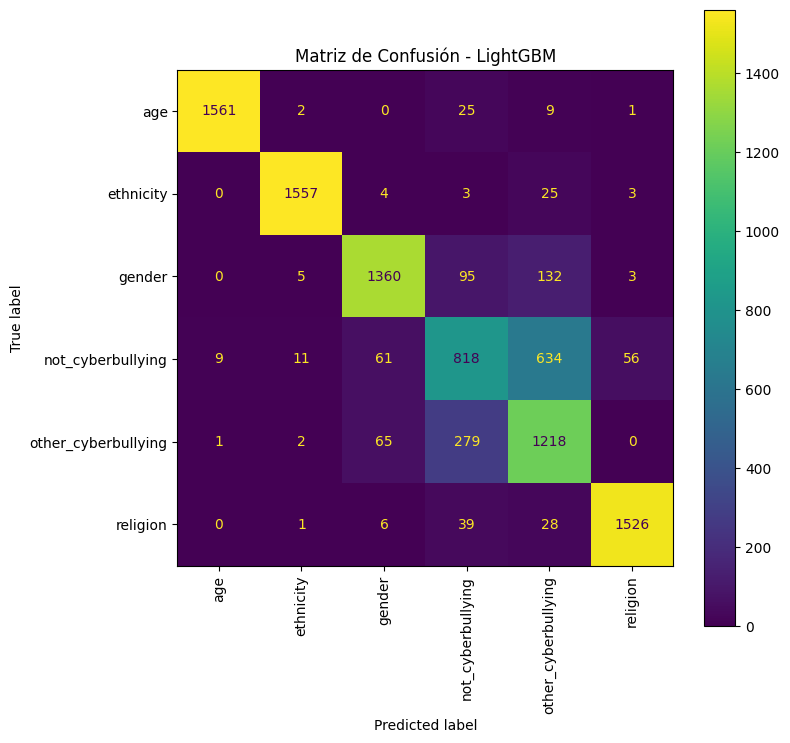


Accuracy: 0.8428556452458329

Recall: 0.8423899409528119


In [0]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
  # 1. Inicializar el modelo LightGBM
  # Usamos los parámetros por defecto, que ya son un punto de partida muy fuerte.
  lgbm_model = lgb.LGBMClassifier(random_state=42)

  # 2. Entrenar el modelo con los mismos datos de entrenamiento
  print("Entrenando el modelo LightGBM...")
  lgbm_model.fit(X_train, y_train)
  print("¡Modelo entrenado!")

  # 3. Realizar predicciones en el conjunto de prueba
  y_pred = lgbm_model.predict(X_test)
  print("\nPredicciones realizadas con LightGBM.")

  # Registre el modelo
  mlflow.sklearn.log_model(lgbm_model, "light-gbm")

  # 4. Evaluar el nuevo modelo
  print("\n--- Reporte de Clasificación (LightGBM) ---")
  print(classification_report(y_test, y_pred))

  # 5. Visualizar la nueva Matriz de Confusión
  print("\n--- Matriz de Confusión (LightGBM) ---")
  fig, ax = plt.subplots(figsize=(8, 8))
  ConfusionMatrixDisplay.from_estimator(lgbm_model, X_test, y_test, xticks_rotation='vertical', ax=ax)
  plt.title("Matriz de Confusión - LightGBM")
  plt.show()

  # 3. Calculo de accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}")

  # Cree y registre la métrica de interés
  mlflow.log_metric("accuracy", accuracy)

  # 4. Calculo de recall
  recall = recall_score(y_test, y_pred, average='macro')
  print(f"\nRecall: {recall}")
  
  # Cree y registre la métrica de interés
  mlflow.log_metric("recall", recall)

